[2.0, 18.0, 34.0, 50.0, 66.0, 82.0, 98.0, 114.0, 130.0, 146.0] 
 [0.9336368874, 0.9223829159, 0.9164815681, 0.9126695634, 0.9097969713, 0.9074378924, 0.9053981965, 0.9035754027, 0.9019094384, 0.9003622636] 
 [0.776739745, 0.8641484994, 0.873921958, 0.8764564405, 0.8772490157, 0.8774267889, 0.8773320788, 0.8770956442, 0.8767758288, 0.8764018612] 
 [399411401.2044, 467144278.2224, 502661985.4464, 525604823.1573, 542893735.8433, 557092030.0158, 569368093.6615, 580338715.6676, 590365447.5578, 599677236.1398] 
 [1557930992.7253, 947984508.5557, 879784398.496, 862098541.8682, 856567877.7705, 855327359.6962, 855988255.2903, 857638118.5633, 859869820.4554, 862479400.9471]


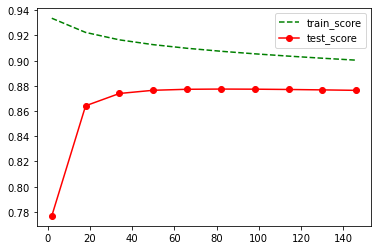

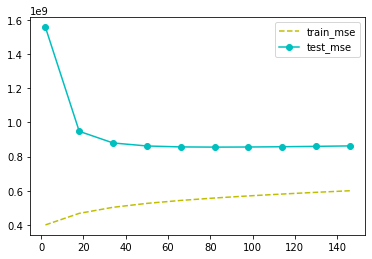

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mserr
from sklearn.decomposition import PCA
#read train and test datasets into pandas DataFrames trainx_df, trainy_df,testx_df
def readDataSets(train_path, test_path,predict_col,index_col=None):
    if index_col==None:
        trainx_df=pd.read_csv(train_path)
        trainy_df=trainx_df[predict_col]
        trainx_df.drop(predict_col,axis=1,inplace=True)
        testx_df=pd.read_csv(test_path)
    else:
        trainx_df=pd.read_csv(train_path,index_col='Id')
        trainy_df=trainx_df[predict_col]
        trainx_df.drop(predict_col,axis=1,inplace=True)
        testx_df=pd.read_csv(test_path,index_col='Id')
    return trainx_df,trainy_df,testx_df
# As a first step of pre-processing remove columns with null value ratio greater than provided limit
def dropFeturesWithNullValuesGreaterThanALimit(trainx_df, testx_df,null_ratio=0.3):
    sample_size=len(trainx_df)
    columns_with_null_values=[[col,float(trainx_df[col].isnull().sum())/float(sample_size)] for col in trainx_df.columns if trainx_df[col].isnull().sum()]
    columns_to_drop=[x for (x,y) in columns_with_null_values if y>null_ratio]
    trainx_df.drop(columns_to_drop,axis=1,inplace=True)
    testx_df.drop(columns_to_drop,axis=1,inplace=True)
    return trainx_df,testx_df
# As a second pre-processing step find all categorical columns and one hot  encode them. Before one hot encode fill all null values with dummy in those columns.  Some categorical columns in trainx_df may not have null values in trainx_df but have null values in testx_df. To overcome this problem we will add a row to the trainx_df with all dummy values for categorical values. Once one hot encoding is complete drop the added dummy column
def oneHotEncode(trainx_df,testx_df):
    categorical_columns=[col for col in trainx_df.columns if            trainx_df[col].dtype==object]
    ordinal_columns=[col for col in trainx_df.columns if col not in categorical_columns]
    dummy_row=list()
    for col in trainx_df.columns:
        if col in categorical_columns:
            dummy_row.append("dummy")
        else:
            dummy_row.append("")
    new_row=pd.DataFrame([dummy_row],columns=trainx_df.columns)
    trainx_df=pd.concat([trainx_df,new_row],axis=0, ignore_index=True)
    testx_df=pd.concat([testx_df],axis=0,ignore_index=True)
    for col in categorical_columns:
        trainx_df[col].fillna(value="dummy",inplace=True)
        testx_df[col].fillna(value="dummy",inplace=True)
    enc = OneHotEncoder(drop='first',sparse=False)
    enc.fit(trainx_df[categorical_columns])
    trainx_enc=pd.DataFrame(enc.transform(trainx_df[categorical_columns]))
    testx_enc=pd.DataFrame(enc.transform(testx_df[categorical_columns]))
    trainx_enc.columns=enc.get_feature_names(categorical_columns)
    testx_enc.columns=enc.get_feature_names(categorical_columns)
    trainx_df=pd.concat([trainx_df[ordinal_columns],trainx_enc],axis=1,ignore_index=True)
    testx_df=pd.concat([testx_df[ordinal_columns],testx_enc],axis=1,ignore_index=True)
    trainx_df.drop(trainx_df.tail(1).index,inplace=True)
    return trainx_df,testx_df
# As a third step of pre-processing fill all missing values for ordinal features
def fillMissingValues(trainx_df,testx_df):
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit(trainx_df)
    trainx_df_filled = imputer.transform(trainx_df)
    trainx_df_filled=pd.DataFrame(trainx_df_filled,columns=trainx_df.columns)
    testx_df_filled = imputer.transform(testx_df)
    testx_df_filled=pd.DataFrame(testx_df_filled,columns=testx_df.columns)
    testx_df_filled.reset_index(drop=True,inplace=True)
    return trainx_df_filled,testx_df_filled
# As a fourth step of pre-processing scale all the features either through Standard scores or MinMax scaling
def scaleFetures(trainx_df,testx_df,scale='Standard'):
    if scale == 'Standard':
        scaler = preprocessing.StandardScaler().fit(trainx_df)
        trainx_df=scaler.transform(trainx_df)
        testx_df=scaler.transform(testx_df)
    elif scale == 'MinMax':
        scaler=preprocessing.MinMaxScaler().fit(trainx_df)
        trainx_df=scaler.transform(trainx_df)
        testx_df=scaler.transform(testx_df)
    return trainx_df,testx_df
#As fifth step of preprocessing apply PCA
def findPrincipalComponents(trainx_df, testx_df):
    pca = PCA().fit(trainx_df)
    itemindex = np.where(np.cumsum(pca.explained_variance_ratio_)>0.999)
    print('np.cumsum(pca.explained_variance_ratio_)',      np.cumsum(pca.explained_variance_ratio_))
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure(np.cumsum(pca.explained_variance_ratio_)[0])
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Principal Components Explained Variance')
    plt.show()
    pca_std = PCA(n_components=itemindex[0][0]).fit(trainx_df)
    trainx_df = pca_std.transform(trainx_df)
    testx_df = pca_std.transform(testx_df)
    return trainx_df,testx_df


# As a fifth step of pre-processing split the trainx_df into tow parts to build a model and test how is it working to pick best model
def splitTrainAndTest(trainx_df, trainy_df,split_ratio=0.3):
    X_train, X_test, y_train, y_test = train_test_split(trainx_df, trainy_df.values.ravel(), test_size=split_ratio, random_state=42)
    return X_train, X_test, y_train, y_test
# Fit Linear Regression Model
def getLinearRegressionModel(X_train, y_train):
    reg=LinearRegression()
    reg = LinearRegression().fit(X_train, y_train)
    return reg
# Fit Regularized Linear regression using Ridge Regression
def getRidgeRegressionModel(X_train, y_train,tolerence=0.0001,reg_par=0.5):
    reg = Ridge(alpha=reg_par,tol=0.01)
    reg = reg.fit(X_train, y_train)
    return reg
# Tune regularization Parameter based on R^2 value or mse
def getRSqureandMSEVsAlphaPlots(X_train, X_test, y_train, y_test,alpha_start=0.1,alpha_end=10,jumps=10):
    score_train=[]
    score_test=[]
    mse_train=[]
    mse_test=[]
    alpha=[]
    for sigma in np.linspace(alpha_start, alpha_end, jumps):
        alpha.append(sigma)
        Ridge_model=getRidgeRegressionModel(X_train, y_train,reg_par=sigma)
        score_train.append(round(Ridge_model.score(X_train, y_train),10))
        score_test.append(round(Ridge_model.score(X_test, y_test),10))
        mse_train.append(round(mserr(y_train,Ridge_model.predict(X_train)),4))
        mse_test.append(round(mserr(y_test,Ridge_model.predict(X_test)),4))
    print(alpha,'\n', score_train, '\n',score_test,'\n', mse_train, '\n',mse_test) 
    plt.figure(1)
    plt.plot(alpha, score_train, 'g--',label="train_score")
    plt.plot(alpha, score_test, 'r-o',label="test_score")
    plt.xlabel='Alpha'
    plt.legend()
    plt.figure(2)
    plt.plot(alpha, mse_train, 'y--',label="train_mse")
    plt.plot(alpha, mse_test, 'c-o',label="test_mse")
    plt.xlabel='Alpha'
    plt.legend()
    plt.show()
# Predict testx_df predict values
def predictTestx(Model, testx_df):
    testpred=pd.DataFrame(Model.predict(testx_df))
    testpred.to_csv("test_pred.csv")

trainx_df,trainy_df,testx_df=readDataSets("V:/DataScience_2019501043/Intro_to_ML/Code_Camp/Linear_Regression/train.csv","V:/DataScience_2019501043/Intro_to_ML/Code_Camp/Linear_Regression/test.csv",predict_col='SalePrice',index_col="Id")
trainx_df,testx_df=dropFeturesWithNullValuesGreaterThanALimit(trainx_df, testx_df,null_ratio=0.5)
trainx_df,testx_df=oneHotEncode(trainx_df,testx_df)
trainx_df,testx_df=fillMissingValues(trainx_df,testx_df)
trainx_df,testx_df=scaleFetures(trainx_df,testx_df,scale='Standard')
#trainx_df,testx_df=findPrincipalComponents(trainx_df, testx_df)
X_train, X_test, y_train, y_test=splitTrainAndTest(trainx_df, trainy_df,split_ratio=0.3)
LRModel=getLinearRegressionModel(X_train, y_train)
RidgeModel=getRidgeRegressionModel(X_train, y_train,tolerence=0.0001,reg_par=0.5)
getRSqureandMSEVsAlphaPlots(X_train, X_test, y_train, y_test,alpha_start=2,alpha_end=146,jumps=10)